Import Libraries

In [1]:
# # Install the latest JAXlib version.
# !pip install --upgrade -q pip jax jaxlib
# # Install Flax at head:
# # !pip install --upgrade -q git+https://github.com/google/flax.git
# !pip install flax
# # !pip install flax==0.5.1
# # !pip install evojax
# !pip install optax

In [2]:
import jax
import optax
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Any, Callable, Sequence, Optional
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax.config import config
# config.enable_omnistaging() # Linen requires enabling omnistaging
# from evojax.util import get_params_format_fn

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Functions

In [3]:
def f_ic(x):
    return 3*c1*(1 / jnp.cosh(a1*(x-x1)))**2 + 3*c2*(1 / jnp.cosh(a2*(x-x2)))**2
def third_deriviative(f):
    return jacfwd(jacfwd(jacfwd(f)))

PINNs Network

In [4]:
n_nodes = 8

class PINNs(nn.Module):
  """PINNs"""
  def setup(self):
    self.layers = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform(), use_bias=False),
                   nn.tanh,
                   nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(1, kernel_init = jax.nn.initializers.glorot_uniform(), use_bias=False)]


  @nn.compact
  def __call__(self, inputs):
      # split the two variables, probably just by slicing
      x, t = inputs[:,0:1], inputs[:,1:2]
      
      def get_u(x, t):
        u = jnp.hstack([x, t])
        for i, lyr in enumerate(self.layers):
          u = lyr(u)
        return u

      u = get_u(x, t)

      # obtain u_t
      def get_u_t(get_u, x, t):
        u_t = jacfwd(get_u, 1)(x, t)
        return u_t
      u_t_vmap = vmap(get_u_t, in_axes=(None, 0, 0))
      u_t = u_t_vmap(get_u, x, t).reshape(-1,1) 
      #obtain u_x
      def get_u_x(get_u, x, t):
        u_x = jacfwd(get_u)(x, t)
        return u_x
      u_x_vmap = vmap(get_u_x, in_axes=(None, 0, 0))
      u_x = u_x_vmap(get_u, x, t).reshape(-1,1)  
      #obtain u_xx    
      def get_u_xx(get_u, x, t):
        u_xx = hessian(get_u)(x,t)
        return u_xx
      u_xx_vmap = vmap(get_u_xx, in_axes=(None, 0, 0))
      u_xx = u_xx_vmap(get_u, x, t).reshape(-1,1)
      #obtain u_xxx    
      def get_u_xxx(get_u, x, t):
        u_xxx = third_deriviative(get_u)(x,t)
        return u_xxx
      u_xxx_vmap = vmap(get_u_xxx, in_axes=(None, 0, 0))
      u_xxx = u_xxx_vmap(get_u, x, t).reshape(-1,1)

      action = jnp.hstack([u,u_x, u_xx, u_xxx, u_t])   
      return action

In [5]:
model = PINNs()
# params = model.init(random.PRNGKey(0), jnp.zeros([2,1]))

In [6]:
seed = 0
key1, key2 = random.split(random.PRNGKey(seed))
a = random.normal(key1, [1,2]) # Dummy input
params = model.init(key2, a) # Initialization call
# jax.tree_map(lambda a: a.shape, params) # Checking output shapes
# model.apply(params, a)
# num_params, format_params_fn = get_params_format_fn(params)

Hyper parameters and data 

In [7]:
v1 = 1
v2 = 0.001
# initial condition
c1, c2, x1, x2 = 0.3, 0.1, 0.4, 0.8
a1, a2 = 0.5*jnp.sqrt(c1/v2), 0.5*jnp.sqrt(c2/v2)

# spatial domain
x_l, x_u = 0., 1.5

# time domain: 0 - t_T
t_T = 2.0 

# fitness evaluation time
t_fitness = 0 

In [8]:
sim = pd.read_csv('kdv.csv')
# sim = pd.read_csv('/home/sungnwy/kdv plot/kdv.csv')
sim['x'], sim['t'] = sim['x'], sim['t']
x_train = np.vstack([sim.x.values, sim.t.values]).T
y_train = sim[['u']].values

x = x_train[:,0:1].reshape(-1)
t = x_train[:,1:2].reshape(-1)
_train1 = np.argwhere(x <= 1.5)
x_train1 = x[_train1].reshape(-1)
t_train1 = t[_train1].reshape(-1)
y_train1 = y_train[_train1].reshape(-1)
_train2 = np.argwhere(x_train1 >= 0.0)
x_train2 = x_train1[_train2].reshape(-1,1)
t_train2 = t_train1[_train2].reshape(-1,1)
y_train2 = y_train1[_train2].reshape(-1,1)
batch_X = jnp.hstack([x_train2, t_train2])
batch_y = y_train2

Loss Function

In [9]:
def make_mse_func(input):
  def mse(params):
    # Define the squared loss for a single pair (x,y)
    def squared_error(input):
        # [u,u_x, u_xx, u_xxx, u_t]
        x = input[:,0:1].reshape(-1,1)
        t = input[:,1:2].reshape(-1,1)
        prediction = model.apply(params, input)
        u, u_x, u_xx, u_xxx, u_t = prediction[:,0:1], prediction[:,1:2], prediction[:,2:3], prediction[:,3:4], prediction[:,4:5]
        # ground truth
        t_u = f_ic(x) 
        _ic = jnp.where((jnp.equal(t, 0)), 1, 0)
        ic_mse = jnp.sum(jnp.square((t_u-u)*_ic))/jnp.sum(_ic)
        # PDE (physics laws): u_t + v1*u*u_x + v2*u_xxx = 0   
        pde = u_t + v1*u*u_x + v2*u_xxx


        # exclude BC points
        _pde = jnp.where((jnp.equal(t, 0)), 0, 1)
        pde = pde*_pde
        pde_mse = jnp.sum(jnp.square(pde))/jnp.sum(_pde)
        pde_mse = pde_mse 
        loss = pde_mse + ic_mse
        return loss
    return squared_error(input)
  return jax.jit(mse) # And finally we jit the result.

# Get the sampled loss
loss = make_mse_func(batch_X)

Weights Update

In [10]:
def update(params, opt_state):
    start = time.time()  
    loss_value, grad = jax.value_and_grad(loss)(params)
    end = time.time()
    global t_fitness
    t_fitness = t_fitness + (end-start)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value
update = jit(update)

Optimizer

In [11]:
alpha = 0.1
# optimizer = optax.adam(learning_rate=alpha) # Choose the method
optimizer = optax.sgd(learning_rate=alpha)
opt_state = optimizer.init(params)
loss_grad_fn = jax.value_and_grad(loss)

Training 

In [12]:
max_iters = 110000
loss_ls = []
t_training = []
runtime = 0
train_iters = 0
while (train_iters < max_iters) and (runtime < 60):
    start = time.process_time()
    params, opt_state, loss_value = update(params, opt_state)
    end = time.process_time()
    t_training.append(end-start)
    loss_ls.append(loss_value)
    # update
    runtime += (end-start)
    train_iters += 1    

Loss Plot

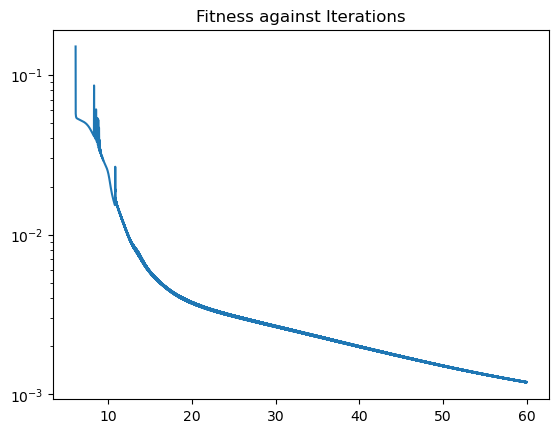

In [13]:
import numpy as np
training_ls = np.cumsum(t_training)

plt.plot(training_ls, loss_ls); plt.yscale('log');
# plt.xlim(800,1000)
# plt.ylim(-1e6,0)
plt.title('Fitness against Iterations')
plt.show()

In [14]:
import pandas as pd

df = pd.DataFrame({'Training Time': training_ls, 'Loss': loss_ls})
#df.to_csv('kdv_sgd_%d.csv'%(seed), index=False)
df

,Training Time,Loss
0,6.070663,0.15085573
1,6.071895,0.06357819
2,6.072706,0.060579788
3,6.073646,0.05987703
4,6.074428,0.059422076
...,...,...
32210,59.994530,0.0011928906
32211,59.996236,0.0011839222
32212,59.997903,0.0011928068
32213,59.999434,0.0011838371


Prediction vs Actual Plot

In [15]:
hello = PINNs()
prediction = hello.apply(params, batch_X)
u, u_x, u_xx, u_xxx, u_t = prediction[:,0:1], prediction[:,1:2], prediction[:,2:3], prediction[:,3:4], prediction[:,4:5]

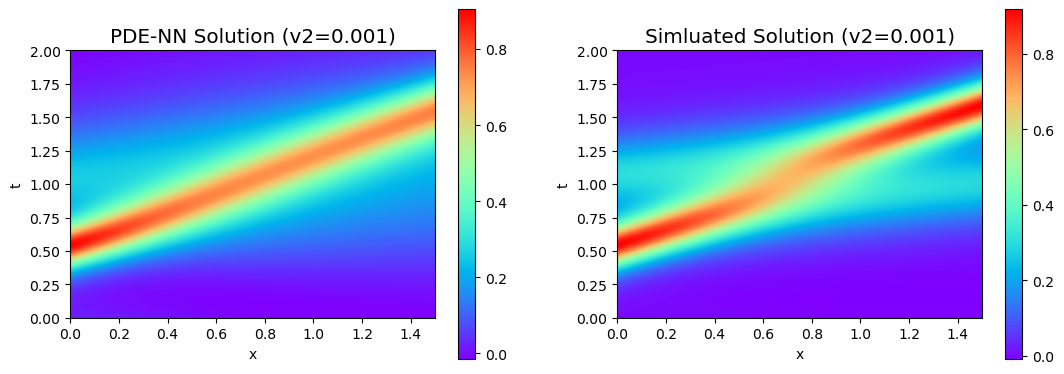

In [16]:
fig = plt.figure(figsize=(20, 10))
u_viz = (u.reshape(201, 77)).T 
ext = [x_l, x_u, 0 ,t_T]    # plot boundary 
ax1 = fig.add_subplot(2,3,1)
mesh =ax1.imshow(u_viz, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=.55); 
plt.colorbar(mesh) 
plt.xlabel('x'); plt.ylabel('t'); 
plt.title('PDE-NN Solution (v2=%s)' %(v2), fontsize='x-large'); 


u_true = (batch_y.reshape(201, 77)).T

ax2 = fig.add_subplot(2,3,2)
mesh2 = ax2.imshow(u_true, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=.55); 
plt.colorbar(mesh2); 
plt.xlabel('x'); plt.ylabel('t'); 
plt.title('Simluated Solution (v2=%s)' %(v2), fontsize='x-large'); 

In [17]:
np.mean((u_viz - u_true)**2)

DeviceArray(0.00337094, dtype=float32)